# Guía 5: Turbulencia Geofísica y Magnetohidrodinámica

Grupo 5

Integrantes:
- Favio Di Ciocco
- Mauro Silberberg

## Funciones de ayuda para cagar los archivos

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import xarray


class Output:
    def __init__(self, path, dt=1, **column_names: list[str]):
        self.path = Path(path)
        self.dt = dt
        self.column_names = column_names

    def load_global_output(self, *names: str):
        if len(names) > 1:
            return pd.concat(
                (self.load_global_output(n) for n in names),
                axis=1,
                join="inner",
            )

        name = names[0]
        data = np.loadtxt(self.path / f"{name}.txt")
        columns = self.column_names[name]
        return pd.DataFrame(data, columns=columns).set_index(columns[0])

    def load_output(self, *names: str):
        if len(names) > 1:
            return xarray.merge(self.load_output(n) for n in names)

        name = names[0]
        files = sorted(self.path.glob(f"{name}.*.txt"))
        index_name, *columns = self.column_names[name]
        data = xarray.DataArray(
            [np.loadtxt(file)[:, 1:] for file in files],
            dims=["time", index_name, "data"],
            coords={
                "data": columns,
                "time": self.dt * np.arange(len(files)),
                index_name: np.loadtxt(files[0], usecols=0),
            },
        ).to_dataset("data")
        if len(data) == 1:
            name = next(iter(data.data_vars))
            data = data.to_array(name=name).squeeze(drop=True)
        return data


## 1) Anisotropía, longitudes características y números de Reynolds

> Haciendo uso del solver ROTH en GHOST,
resuelva numéricamente la ecuación para un flujo rotante incompresible
con densidad uniforme $ρ_0 = 1$ y $ν = 2 × 10^{−3}$
en un recinto cubico $2π × 2π × 2π$ y resolución espacial `Nx = Ny = 192` y `Nz = 48`.
Hacer uso del Material Adicional.
Para condiciones iniciales nulas para el campo de velocidades
y un forzado mecánico aleatorio con amplitud `f0 = 0.75`
y número de onda `kup = kdn = 1`
integre las ecuaciones hasta $t = 25$.
En el forzado actualice las fases al azar
(con la opción `rand = 2` en el archivo de entrada)
con un tiempo de correlación `cort = 0.5`
(de esta forma las fases de los modos Fourier en el forzado cambiarán cada $∆t = 0.5$).
Utilice una frecuencia de rotación $Ω_z = 8$ y
guarde los espectros cinéticos cada $∆t ∼ 0.5$ y el campo de velocidades cada $∆t ∼ 1.5$.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray
from common import Output
from ghost_xarray import open_dataset


plt.rc("figure", dpi=100, figsize=(6, 3))

nu = 2e-3
t_max = 25
Δt_save_spectrum = 0.5
Δt_save_field = 1.5

output = Output(
    "problema1/output/",
    dt=Δt_save_spectrum,
    balance=["time", "<v^2>", "<omega^2>", "mechanic injection rate"],
    helicity=["time", "kinetic helicity"],
    kspectrum=["k", "Ev(k)"],
    kspecpara=["k", "Ev(kz)", "Ev_perp(kz)", "Ev_z(kz)"],
    kspecperp=["k", "Ev(kp)", "ev_x,y(kp,kz=0)", "ev_z(kp,kz=0)"],
)

> a) Utilizando la resolución espacial y la condición CFL,
y asumiendo que en el estado turbulento la velocidad característica será $u ∼ 1$,
elija el paso temporal $dt$ que utilizará para la integración numérica.

In [3]:
N = np.array([192, 192, 48])
Δx = 2 * np.pi / np.max(N)
U = 1
Δt_CFL = Δx / U

Δt_CFL

0.032724923474893676

In [4]:
Δt = 0.004

for k, v in {
    "step": Δt,
    "total_steps": t_max / Δt,
    "save_field_steps": Δt_save_field / Δt,
    "save_spectrum_steps": Δt_save_spectrum / Δt,
}.items():
    print(f"{k:>20} = {v:8.3f}")

                step =    0.004
         total_steps = 6250.000
    save_field_steps =  375.000
 save_spectrum_steps =  125.000


> b) Grafique la energía, la enstrofía y la tasa de inyección de energía en función del tiempo
(ayuda: ver la segunda, tercera y cuarta columna del archivo `’balance.txt’`).
Verifique numéricamente la relación
> 
> $$ \frac{dE}{dt} = ε − 2νZ \tag{1} $$
> 
> donde $Z$ es la enstrofía.
Interprete el resultado.

In [5]:
data = output.load_global_output("balance")
data.head(2)

,<v^2>,<omega^2>,mechanic injection rate
time,,,
0.00,0.00000,0.00000,0.000000
0.04,0.00084,0.00084,0.020215


array([<AxesSubplot: xlabel='time'>, <AxesSubplot: xlabel='time'>,
       <AxesSubplot: xlabel='time'>], dtype=object)

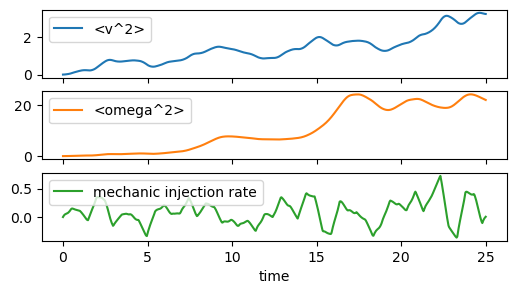

In [6]:
data.plot(subplots=True)

In [7]:
def gradient(df):
    return df.diff() / df.index.to_series().diff()

<AxesSubplot: xlabel='time'>

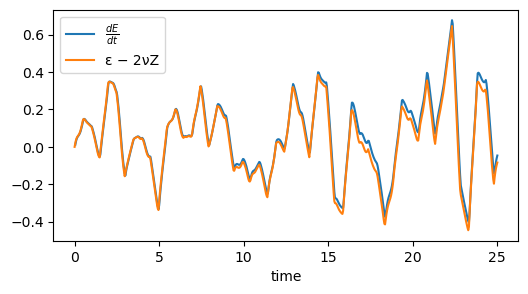

In [8]:
lhs = 0.5 * gradient(data["<v^2>"])
rhs = data["mechanic injection rate"] - 2 * nu * data["<omega^2>"]

pd.DataFrame({r"$\frac{dE}{dt}$": lhs, r"ε − 2νZ": rhs}).plot()

> c) Identifique el tiempo aproximado en el que el sistema llega al régimen turbulento $t^*$.
Grafique el espectro de energía isótropo $E(k)$,
el espectro de energía perpendicular $E(k_⊥)$,
y el espectro de energía paralelo $E(k_∥)$,
promediados en el tiempo desde $t^*$ hasta $t = 25$
(ayuda: el código guarda el espectro perpendicular en los archivos `’kspecperp.*.txt’`,
y el espectro paralelo en `’kspecpara.*.txt’`).
Compare el espectro perpendicular con la predicción fenomenológica.

Elegimos el tiempo $t^*$ como el momento donde el sistema llega al máximo de enstrofía $\langle \omega^2 \rangle$,
es decir, $t^* \approx 18$.

In [9]:
data = output.load_output("kspectrum", "kspecperp", "kspecpara")[["Ev(k)", "Ev(kz)", "Ev(kp)"]]
data

<xarray.Dataset>
Dimensions:  (time: 51, k: 98)
Coordinates:
  * time     (time) float64 0.0 0.5 1.0 1.5 2.0 2.5 ... 23.0 23.5 24.0 24.5 25.0
  * k        (k) float64 0.0 1.0 2.0 3.0 4.0 5.0 ... 93.0 94.0 95.0 96.0 97.0
Data variables:
    Ev(k)    (time, k) float64 nan 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    Ev(kz)   (time, k) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... nan nan nan nan nan
    Ev(kp)   (time, k) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 nan

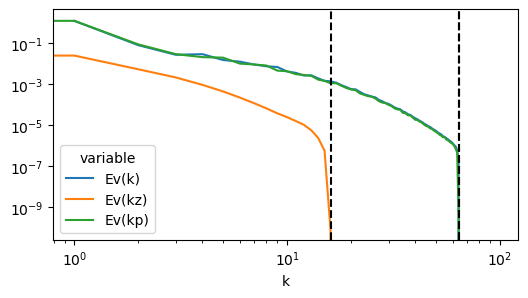

In [10]:
(
    data
    .sel(time=slice(21, None))
    .mean("time")
    .to_array()
    .plot.line(x="k", xscale="log", yscale="log")
)
for n in (N/3):
    plt.axvline(n, linestyle="--", color="black")

Para el espectro perpendicular,
la predicción fenomenológica es que sigue leyes de potencias,
con un exponente $-2$ para el rango inercial,
y un exponente $-5/3$ en el rango disipativo.
Como el $k_\Omega$ de Zeman es mucho mayor al que se resuelve en la simulacion,
no se observa esta última ley de potencia en el espectro.

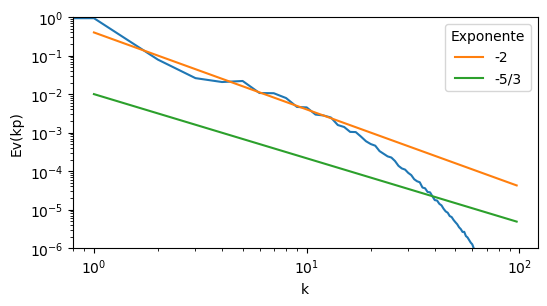

In [11]:
Ek_perp = data["Ev(kp)"].sel(time=slice(18, None)).mean("time")
Ek_perp.plot.line(x="k", xscale="log", yscale="log")
plt.ylim(1e-6, 1)

k = Ek_perp.k
plt.plot(k, 0.4 * k**-2, label="-2")
plt.plot(k, 0.01 * k**-(5/3), label="-5/3")
plt.legend(title="Exponente")

> d) Utilizando los espectros de energía calcule
la longitud integral isótropa $L$,
la longitud perpendicular $L_⊥$,
y la longitud paralela $L_∥$ en función del tiempo.

La longitudes integrales las podemos calcular como

$$ L = \frac{1}{N} \int \frac{2\pi}{k} \; E(k) \; dk $$

donde $ N = \int E(k) \; dk $.

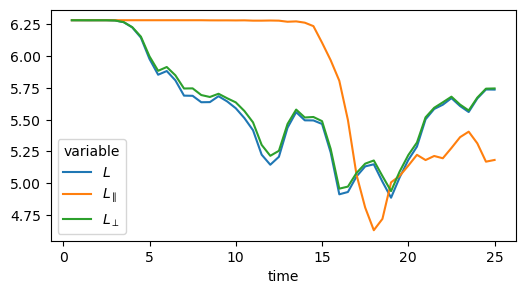

In [12]:
def longitud(E):
    E = E.isel(k=slice(1, None))  # saco k=0
    k = E.k
    L_medio = 2 * np.pi * (E / k).sum("k") / E.sum("k")
    return L_medio


L = data.groupby("time").map(longitud)
L.rename(
    {
        "Ev(k)": "$L$",
        "Ev(kp)": "$L_\perp$",
        "Ev(kz)": "$L_\parallel$",
    }
).to_array().plot.line(x="time")

Para tiempos cortos,
se observa que las longitudes son iguales al tamaño de la caja.
A medida que evoluciona el fluido,
el fluido se empieza a mezclar en la dirección perpendicular a la rotación,
disminuyendo la escala característica de longitud.
En cambio,
en la dirección paralela,
la rotación produce la conformación de estructuras cilindricas a lo largo de dicha dirección.
Al llegar al tiempo $t^*$,
la turbulencia empieza a competir contra el término de rotación,
y la energía se empieza a transferir a escalas de longitud más pequeñas
en la dirección paralela.

> e) Estime el número de Reynolds, el número de Rossby, y el número de onda de Zeman $k_Ω$ en el régimen
turbulento.
Note que como el forzado varía aleatoriamente en el tiempo también puede cambiar de signo.
Por lo tanto, puede obtener una mejor estimación de $k_Ω$
asumiendo que en el estado turbulento $dE/dt ∼ 0$ (en promedio temporal)
y usando $ε ∼ 2νZ$.
Compare $k_Ω$ con el mayor número de onda resuelto.
¿Son isótropas las estructuras en las escalas más pequeñas de este flujo?

Los números de Reynolds $Re$, Rossby $Ro$ y Zeman $k_\Omega$ son:

$$ Re = \frac{UL}{\nu} $$

$$ Ro = \frac{U}{2\Omega L} $$

$$ k_{Zeman} = \left(\frac{\Omega^3}{\epsilon}\right)^\frac{1}{2} $$

In [13]:
U = 1
L = 5
Ω = 8
ε = 2 * nu * output.load_global_output("balance")["<omega^2>"].loc[18:].mean()

pd.Series(
    dict(
        Re=U * L / nu,
        Ro=U / (2 * Ω * L),
        k_Zeman=(Ω**3 / ε) ** 0.5,
    )
)

Re         2500.0000
Ro            0.0125
k_Zeman      77.8489
dtype: float64

Como el número de Reynolds es $Re \sim 2500$,
el flujo se encuentra en un régimen turbuluento.

Por otro lado,
al ser el número de Rossby muy pequeño,
las fuerzas de Coriolis dominan la dinámica.

Finalmente,
como el $k$ de Zeman es mayor al $k$ máximo resuelto en la simulación,
no nos encontramos en el régimen anisótropo.

> f) Para algún tiempo $t > t^*$, grafique un corte de la vorticidad $ω_z$ en el plano $x − z$.
¿Qué observa? ¿Son compatibles las estructuras con lo que esperaba?

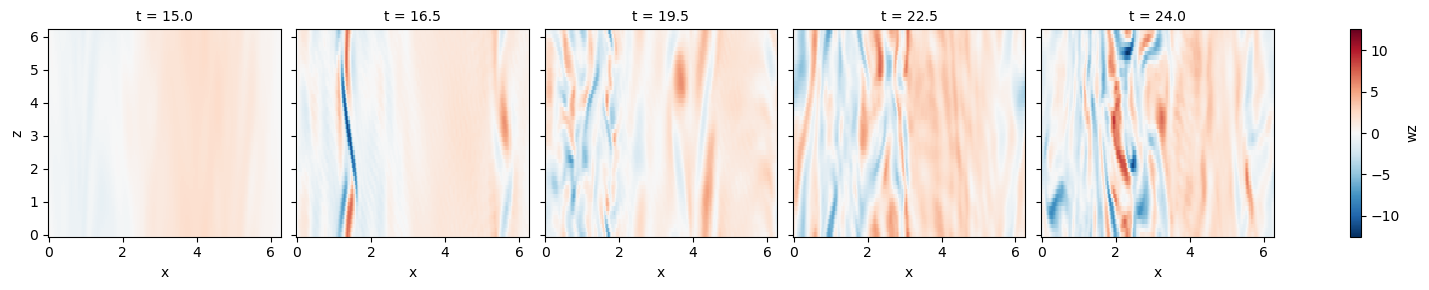

In [14]:
def derivative(x, dim):
    return x.diff(dim) / x[dim].diff(dim)


def rotor(v):
    return xarray.Dataset(
        dict(
            wx=derivative(v["vz"], "y") - derivative(v["vy"], "z"),
            wy=derivative(v["vx"], "z") - derivative(v["vz"], "x"),
            wz=derivative(v["vy"], "x") - derivative(v["vx"], "y"),
        )
    )


w = open_dataset(
    output.path,
    ["vx", "vy", "vz"],
    dt=1.5,
    shape=tuple(N),
    dtype="float32",
).pipe(rotor)

(
    w["wz"]
    .isel(y=96)
    .sel(t=[15, 17, 20, 23, 25], method="nearest")
    .plot(x="x", y="z", col="t")
)

Una vez que se supera el tiempo $t^*$,
se observa el efecto de la turbulencia.
Sin embargo,
se observan estructuras alargadas en la dirección de rotación,
ya que la turbulencia no supera al término de rotación en la dinámica.

## 2)

> Rehacer el Problema 1) considerando ahora un flujo estratificado en la aproximación de Boussinesq.
Utilice el solver BOUSS de GHOST, nuevamente con condiciones iniciales nulas para el campo de velocidad,
con forzado mecánico aleatorio con amplitud `f0 = 0.75` centrado en los modos Fourier con $k$ entre $1$ y $4$
(i.e., `kdn = 1`, `kup = 4`)
con las mismas propiedades temporales que en el problema anterior (`rand=2`, `cort=0.5`),
y sin fluctuaciones iniciales en la temperatura y sin fuentes térmicas ($c0 = s0 = 0$).
Utilice
una frecuencia de Brunt-Väisälä $N = 8$,
viscosidad cinemática y difusividad térmica $ν = κ = 2 × 10^{−3}$ y
$192 × 192 × 48$ puntos de resolución espacial en un dominio cúbico con tamaño $2π × 2π × π/2$.

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray
from ghost_xarray import open_dataarray
from common import Output


plt.rc("figure", dpi=100, figsize=(6, 3))

t_max = 25
Δt_save_spectrum = 0.5
Δt_save_field = 1.5

output = Output(
    "problema2/output/",
    dt=Δt_save_spectrum,
    balance=["time", "<v²>", "<ω²>", "mechanic injection rate"],
    helicity=["time", "kinetic helicity"],
    scalar=["time", "<θ²>", "<|∇θ|²>", "temperature injection rate"],
    kspectrum=["k", "Ev(k)"],
    kspecpara=["k", "Ev(kz)", "Ev_perp(kz)", "Ev_z(kz)"],
    kspecperp=["k", "Ev(kp)", "ev_x,y(kp,kz=0)", "ev_z(kp,kz=0)"],
)

> a) Compare las resoluciones espaciales $∆x$, $∆y$ y $∆z$ del problema con las del Problema 1).
¿Como justifica los cambios en el tamaño del dominio y en la resolución?

In [16]:
N = np.array([192, 192, 48])
Δx = 2 * np.pi * np.array([1, 1, 1/4]) / N

Δx_problema1 = 2 * np.pi / N
Δx / Δx_problema1

array([1.  , 1.  , 0.25])

El tamaño del dominio en la dirección $z$ se achicó en un factor 1/4 respecto el problema anterior.
Pero, ahora, la resolución espacial es igual en todas las direcciones.

In [17]:
Δx

array([0.03272492, 0.03272492, 0.03272492])

In [18]:
coords = {x: dx * np.arange(n) for x, dx, n in zip("xyz", Δx, N)}

> b) Grafique la energía cinética, la energía potencial, y el cociente entre ambas.
¿Como son las fluctuaciones térmicas comparadas con la velocidad?

In [19]:
data = output.load_global_output("balance", "scalar")[["<v²>", "<θ²>"]].assign(
    **{"<θ²>/<v²>": lambda x: x["<θ²>"] / x["<v²>"]}
)
data.head(2)

,<v²>,<θ²>,<θ²>/<v²>
time,,,
0.00,0.000000,0.000000,NaN
0.05,0.001216,0.000023,0.018603


array([<AxesSubplot: xlabel='time'>, <AxesSubplot: xlabel='time'>,
       <AxesSubplot: xlabel='time'>], dtype=object)

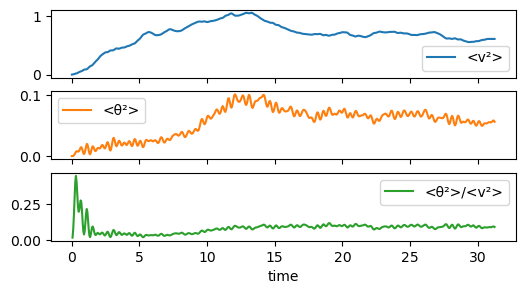

In [20]:
data.plot(subplots=True)

Luego de un transitorio,
la enegía cinética crece mucho más rápido que la energía potencial,
y se estabiliza alrededor de $t \sim 15$,
donde empieza la etapa turbulenta.
En dicha etapa,
la relación entre ambas energías es del orden de $ \sim 10\%$.

In [21]:
data.loc[20:].describe()

,<v²>,<θ²>,<θ²>/<v²>
count,226.000000,226.000000,226.000000
mean,0.660667,0.063383,0.096078
std,0.054847,0.006738,0.008159
min,0.553294,0.049713,0.075083
25%,0.608588,0.057621,0.090510
50%,0.673928,0.064220,0.096255
75%,0.711357,0.068242,0.102427
max,0.733268,0.077732,0.113799


> c) Grafique el espectro de energía cinética isótropo $E(k)$,
el espectro de energía cinética perpendicular $E(k_⊥)$,
y el espectro de energía cinética paralelo $E(k_∥)$
promediados en el tiempo, para tiempos suficientemente tardíos.
Compare los espectros con las predicciones fenomenológicas.

In [22]:
data = output.load_output("kspectrum", "kspecperp")[["Ev(k)", "Ev(kp)"]]
data_para = output.load_output("kspecpara")["Ev(kz)"]

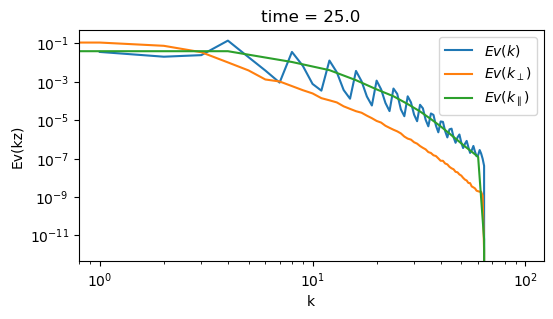

In [23]:
(
    data
    .isel(time=-1)
    .to_array()
    .plot.line(x="k", xscale="log", yscale="log")
)
data_para.isel(time=-1).plot.line(x="k", xscale="log", yscale="log")
plt.legend([r"$Ev(k)$",r"$Ev(k_\perp)$",r"$Ev(k_\parallel)$"])

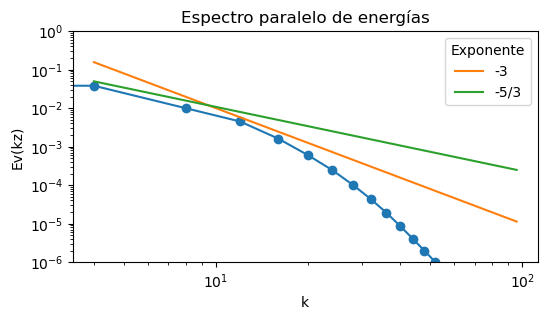

In [24]:
tmp = data_para.sel(time=slice(20, None)).mean("time")
tmp.plot.line(x="k", xscale="log", yscale="log", marker="o")
plt.ylim(1e-6, 1)

k = tmp.k
plt.plot(k, 10 * k**(-3), label="-3")
plt.plot(k, 0.5 * k**(-5/3), label="-5/3")
plt.legend(title="Exponente")
plt.title("Espectro paralelo de energías")
plt.show()

In [25]:
def fit_power_law(x):
    p, cov = np.polyfit(np.log(x.k), np.log(x), 1, cov=True)
    return pd.Series({"pendiente": p[0], "error": cov[0,0]**0.5})

pd.DataFrame({
    "inicio": fit_power_law(tmp.isel(k=slice(1, 4))),
    "medio": fit_power_law(tmp.isel(k=slice(4, 7))),
    "final": fit_power_law(tmp.isel(k=slice(8, 12))),
}).round(2)

,inicio,medio,final
pendiente,-1.95,-4.63,-7.51
error,0.00,0.13,0.17


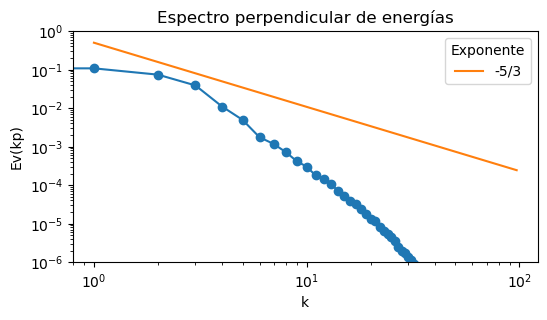

In [26]:
tmp = data["Ev(kp)"].sel(time=slice(20, None)).mean("time")
tmp.plot.line(x="k", xscale="log", yscale="log", marker="o")
plt.ylim(1e-6, 1)

k = tmp.k
plt.plot(k, 0.5 * k**(-5/3), label="-5/3")
plt.legend(title="Exponente")
plt.title("Espectro perpendicular de energías")
plt.show()

In [27]:
def fit_power_law(x):
    p, cov = np.polyfit(np.log(x.k), np.log(x), 1, cov=True)
    return pd.Series({"pendiente": p[0], "error": cov[0,0]**0.5})

pd.DataFrame({
    "inicio": fit_power_law(tmp.sel(k=slice(5, 20))),
}).round(2)

,inicio
pendiente,-4.12
error,0.07


Para el espectro perpendicular,
esperábamos que el espectro siga una ley de potencias con exponente $k^{-5/3}$.
En cambio,
para el espectro paralelo,
esperábamos que siga dos leyes de potencia:
$k^{-3}$ y $k^{-5/3}$,
para regiones por debajo y por encima del $k$ de Ozmidov,
respectivamente.
Esto no se observa en los gráficos de los espectros.

> d) Utilizando los espectros de energía calcule
la longitud integral isótropa $L$,
la longitud perpendicular $L_⊥$,
y la longitud paralela $L_∥$
en función del tiempo.
Calcule la longitud paralela obtenida por análisis dimensional
(la "longitud de empuje"), $L_B = 2π/k_B$ (con $k_B = N/U$, donde $U$ es la velocidad típica del fluido),
y compare esta longitud con la obtenida a partir del espectro, $L_∥$.
Utilizando estas longitudes estime el número de Reynolds y los números de Froude paralelo y perpendicular (puede asumir $U_⊥ ∼ U$).

In [28]:
U = 1
N = 8
nu = 2e-3
k_B = N / U
L_B = 2 * np.pi / k_B

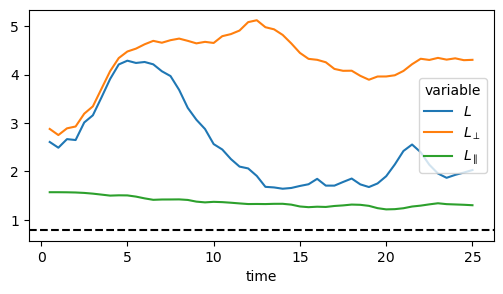

In [29]:
def longitud(E):
    E = E.isel(k=slice(1, None))  # saco k=0
    k = E.k
    L_medio = 2 * np.pi * (E / k).sum("k") / E.sum("k")
    return L_medio

data_L = data.groupby("time").map(longitud)
data_L["$L_\parallel$"] = data_para.groupby("time").map(longitud)
data_L.rename({"Ev(k)": "$L$", "Ev(kp)": "$L_\perp$"}).to_array().plot.line(x="time")
plt.axhline(L_B, label="$L_B$", color="black", linestyle="--")

El numero de Froude $F_r$ lo podemos calcular como:

$$ F_r = \frac{U}{N L} $$

In [30]:
def reynolds_number(U, L, nu):
    return U * L / nu


def froude_number(U, N, L):
    return U / (N * L)


L = {"parallel": 1.5, "perpendicular": 4.5}
pd.DataFrame(
    {
        orientation: dict(
            Reynolds=reynolds_number(U=1, L=Lo, nu=nu),
            Froude=froude_number(U=1, L=Lo, N=N),
        )
        for orientation, Lo in L.items()
    }
).round(3)

,parallel,perpendicular
Reynolds,750.000,2250.000
Froude,0.083,0.028


Basados en el número de Reynolds,
podemos decir que el sistema es más turbulento en la dirección perpendicular.
Por otro lado,
los números de Froude son menores a $1$,
que no se corresponde con los casos de fuerte o débil estratificación
\cite{Davidson, p. 443}.

> e) Para algún tiempo $t > t^*$,
grafique un corte de las fluctuaciones de temperatura $π$ en el plano $x − z$.
¿Qué observa? ¿Son compatibles las estructuras con lo que esperaba?

In [31]:
th = open_dataarray(
    output.path,
    "th",
    dt=1.5,
    shape=coords,
    dtype="float32",
)
th

<xarray.DataArray 'th' (t: 17, x: 192, y: 192, z: 48)>
dask.array<concatenate, shape=(17, 192, 192, 48), dtype=float32, chunksize=(1, 192, 192, 48), chunktype=numpy.ndarray>
Coordinates:
  * x        (x) float64 0.0 0.03272 0.06545 0.09817 ... 6.152 6.185 6.218 6.25
  * y        (y) float64 0.0 0.03272 0.06545 0.09817 ... 6.152 6.185 6.218 6.25
  * z        (z) float64 0.0 0.03272 0.06545 0.09817 ... 1.44 1.473 1.505 1.538
  * t        (t) float64 0.0 1.5 3.0 4.5 6.0 7.5 ... 18.0 19.5 21.0 22.5 24.0

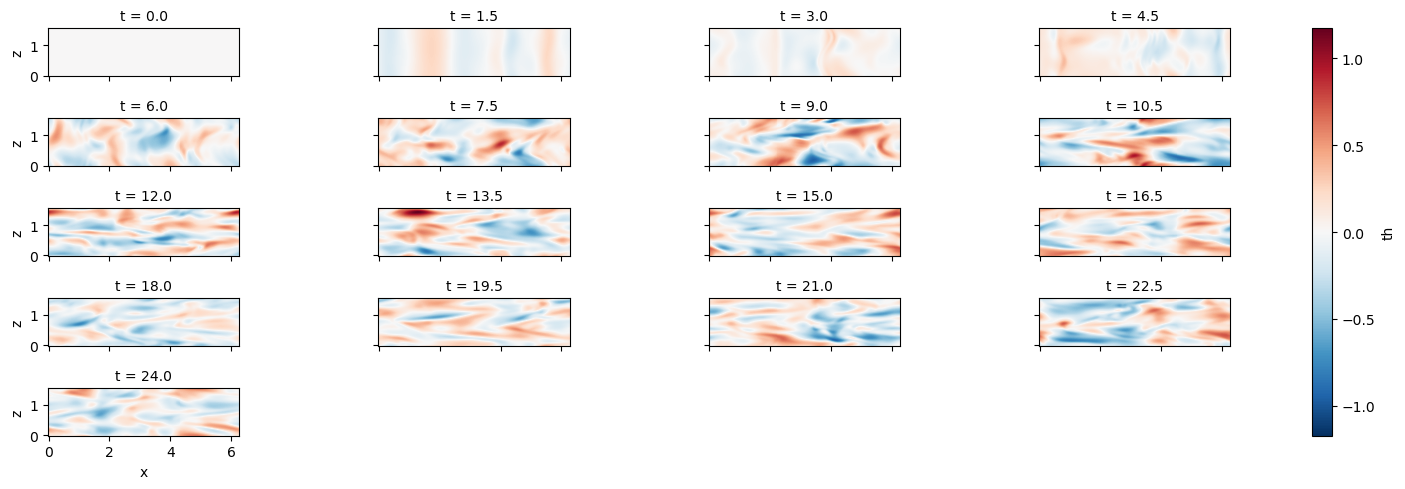

In [32]:
ax = (
    th
    .isel(y=96)
    # .sel(t=[10, 20], method="nearest")
    .plot(x="x", y="z", col="t", col_wrap=4, size=1, aspect=4)
)
for ax in ax.axes.flat:
    ax.set_aspect("equal")

A medida que se desarrolla la turbulencia,
se observan estructuras alargadas en la dirección perpendicular.
Estas se mantienen incluso para $t$ grandes,
por lo que el sistema no llega a una etapa de turbulencia isótropa.

## 3) Magnetohidrodinámica

> Haciendo uso del solver MHDB,
resuelva numéricamente las ecuaciones MHD
con un campo guía $B_0 = B_0 ẑ$
desde $t = 0$ hasta $t = 20$
usando $dt = 4 × 10^{−3}$
con $128 × 128 × 64$ puntos espaciales en un dominio con tamaño 2π × 2π × 2π.
Imponga un campo guía $B_0 = 2$,
y utilice una viscosidad cinemática y difusividad magnética $ν = η = 3.5 × 10^{−3}$.
Utilice condiciones iniciales aleatorias para el campo de velocidad y magnético
con amplitud igual a $1$
entre `kdn = 1` y `kup = 10`,
con una correlación cruzada $K$ mayor a $∼0.3$,
y sin fuerzas externas.
En particular,
deje decaer libremente al sistema
(si a $t = 0$ $K$ es menor que $∼0.3$,
cambie el valor de la semilla *seed* para el generador de números al azar en el archivo `"parameter.inp"`).

In [33]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from common import Output

output = Output(
    "problema3/output",
    dt=4e-3 * 125,
    balance=["time", "<v^2>+<b^2>", "<omega^2>", "<j^2>"],
    energy=["time", "<v^2>", "<b^2>"],
    helicity=["time", "kinetic helicity", "magnetic helicity"],
    cross=["time", "<v.b>", "<a^2>"],
    kspectrum=["k", "Ev"],
    mspectrum=["k", "Eb"],
)

> a) Grafique la energía total y la helicidad cruzada en función del tiempo.
¿Decaen con la misma tasa?

In [34]:
data = output.load_global_output("balance", "cross")
data.head(2)

,<v^2>+<b^2>,<omega^2>,<j^2>,<v.b>,<a^2>
time,,,,,
0.00,2.210863,9.946115,9.243430,0.710863,0.695657
0.04,2.205510,9.831027,9.255789,0.709432,0.699903


Para ver la tasa de decaimiento,
vemos la derivada (a menos de un factor $\Delta t$):

<AxesSubplot: xlabel='time'>

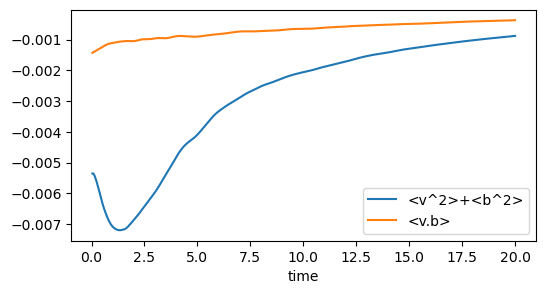

In [35]:
data[["<v^2>+<b^2>", "<v.b>"]].diff().plot()

La energía $\langle v^2 \rangle + \langle b^2 \rangle$
decae más rápido que
la correlación cruzada $\langle v \cdot b \rangle$.

> b) Grafique la energía cinética y magnética en función del tiempo.

<AxesSubplot: xlabel='time'>

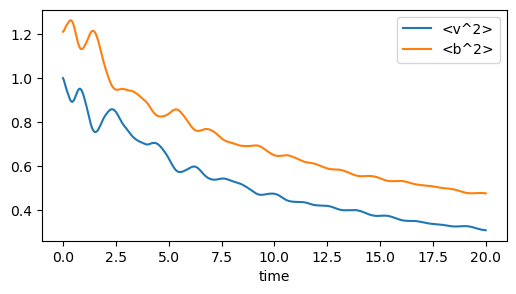

In [36]:
output.load_global_output("energy").plot()

> c) Grafique el producto
>
> $$\frac{u · b}{(⟨u^2 ⟩⟨b^2 ⟩)^{1/2}}$$
>
> ¿A qué valor evoluciona? ¿Por qué?

In [37]:
data = output.load_global_output("energy", "cross")
data.head(2)

,<v^2>,<b^2>,<v.b>,<a^2>
time,,,,
0.00,1.00000,1.210863,0.710863,0.695657
0.04,0.99089,1.214620,0.709432,0.699903


La correlación entre $v$ y $b$ aumenta a medida que pasa el tiempo,
casi llegando a $1$ para el fin de la simulación.
Es decir,
los campos se alinean a medida que evolucionan.

<AxesSubplot: xlabel='time'>

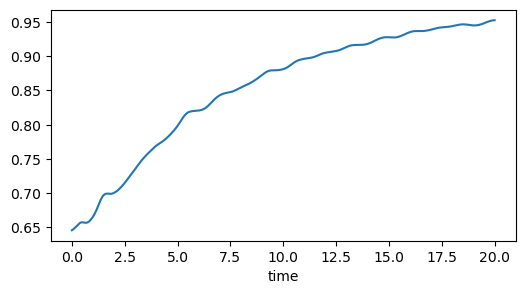

In [38]:
K = data["<v.b>"] / (data["<v^2>"] * data["<b^2>"])**0.5
K.plot()

> d) Grafique los espectros de la energía cinética y magnética.
¿Qué pendientes observa en dichos espectros?

In [39]:
data = output.load_global_output("balance")
data.head(2)

,<v^2>+<b^2>,<omega^2>,<j^2>
time,,,
0.00,2.210863,9.946115,9.243430
0.04,2.205510,9.831027,9.255789


$$ \frac{dE}{dt} = ε − 2νZ - 2\eta \int \langle j^2 \rangle $$

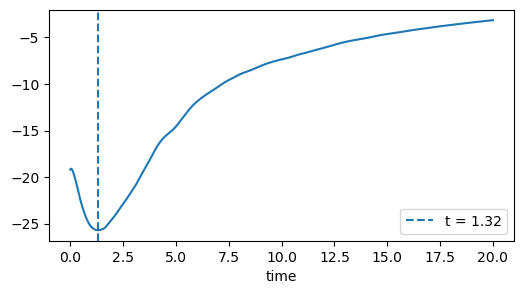

In [40]:
dEdT = -(data["<j^2>"] + data["<omega^2>"])
t_max = dEdT.idxmin()

dEdT.plot()
plt.axvline(t_max, linestyle="--", label=f"t = {t_max:.2f}")
plt.legend()

In [41]:
data = output.load_output("kspectrum", "mspectrum")
data

<xarray.Dataset>
Dimensions:  (time: 41, k: 65)
Coordinates:
  * time     (time) float64 0.0 0.5 1.0 1.5 2.0 2.5 ... 18.0 18.5 19.0 19.5 20.0
  * k        (k) float64 1.0 2.0 3.0 4.0 5.0 6.0 ... 61.0 62.0 63.0 64.0 65.0
Data variables:
    Ev       (time, k) float64 0.2284 0.1191 0.04924 0.03421 ... 0.0 0.0 0.0 0.0
    Eb       (time, k) float64 0.3878 0.08431 0.04173 0.02765 ... 0.0 0.0 0.0

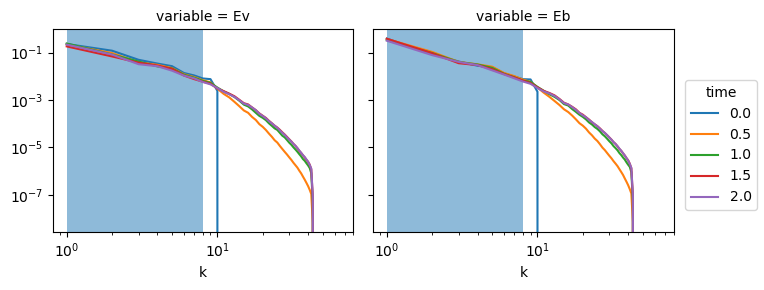

In [42]:
ax = data.isel(time=slice(0, 5)).to_array().plot.line(col="variable", x="k", yscale="log", xscale="log")
for ax in ax.axes.flat:
    ax.axvspan(1, 8, alpha=0.5)

In [43]:
def fit_power_law(x):
    p, cov = np.polyfit(np.log(x.k), np.log(x), 1, cov=True)
    return pd.Series({"pendiente": p[0], "error": cov[0,0]**0.5})

data.isel(time=2).sel(k=slice(0, 8)).map(fit_power_law).to_dataframe()

,Ev,Eb
dim_0,,
pendiente,-1.718484,-1.835129
error,0.070051,0.076639


La pendientes en las regiones azules son consistentes con -5/3.

In [44]:
-5/3

-1.6666666666666667

In [45]:
data.isel(time=2).sel(k=slice(15, 35)).map(fit_power_law).to_dataframe()

,Ev,Eb
dim_0,,
pendiente,-5.744405,-5.654859
error,0.114242,0.119550
